In [1]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [2]:
class Maze:
    def __init__(self, filename):
        """Initialize the maze from a text file."""
        self.maze = self.read_maze(filename)
        self.rows, self.cols = self.maze.shape
        self.start = self.find_position('A')
        self.goal = self.find_position('B')
        
    def read_maze(self, filename):
       #Read the maze from the text file. 
        with open(filename, 'r') as file:
            maze_lines = file.readlines()
        
        #maze dimensions
        maze_lines = [line.strip() for line in maze_lines]
        rows = len(maze_lines)
        cols = max(len(line) for line in maze_lines)
        
        #converting the maze to a numpy array.
        maze = np.full((rows, cols), '#')  #the walls are hashtags '#####'
        
        # fill the maze array
        for i, line in enumerate(maze_lines):
            for j, char in enumerate(line):
                maze[i, j] = char
        return maze
    
    def find_position(self, char):
        """Find the position of a character in the maze."""
        positions = np.where(self.maze == char)
        if len(positions[0]) == 0:
            raise ValueError(f"Character '{char}' not found in maze") #if character is not in maze
        return (positions[0][0], positions[1][0])
    
    def get_neighbors(self, state):
        """Return all valid adjacent cells (up, down, left, right)."""
        row, col = state
        neighbors = []
        moves = [
            ('up', (-1, 0)),
            ('right', (0, 1)),
            ('down', (1, 0)),
            ('left', (0, -1))
        ]
        
        for action, (dr, dc) in moves:
            new_row, new_col = row + dr, col + dc
            
            #ensure the new position is within the maze boundaries
            if 0 <= new_row < self.rows and 0 <= new_col < self.cols:
                # Check if the new position is not a wall
                if self.maze[new_row, new_col] != '#':
                    neighbors.append((action, (new_row, new_col)))
        return neighbors
    
    def manhattan_distance(self, state1, state2):
        """Calculate Manhattan distance between two states."""
        return abs(state1[0] - state2[0]) + abs(state1[1] - state2[1])
    
    def solve(self, algorithm="greedy"):        
        # Node for the start state
        start_node = Node(state=self.start, parent=None, action=None, cost=0)
        
        # Initialize the frontier with the start node
        frontier = []
        
        if algorithm == "greedy":  #greedy, priority = h(n)
            priority = self.manhattan_distance(self.start, self.goal)
            
        else:  #A*, priority = g(n) + h(n)
            priority = self.manhattan_distance(self.start, self.goal) + 0  # g(n) = 0 for start
        
        # ADD the start node to the frontier
        heapq.heappush(frontier, (priority, id(start_node), start_node))
        
        # Initialize the explored set
        explored = set()
        
        # Initialize a dictionary to track frontier nodes by state
        frontier_states = {self.start: start_node}
        
        while frontier:
            # Get the node with the lowest priority
            _, _, current_node = heapq.heappop(frontier)
            
            # Remove from frontier states (its now explored)
            if current_node.state in frontier_states:
                del frontier_states[current_node.state]
            
            # Check if we've reached the goal
            if current_node.state == self.goal:
                # Reconstruct the path
                path = []
                while current_node.parent is not None:
                    path.append((current_node.action, current_node.state))
                    current_node = current_node.parent
                path.reverse()
                return path, explored
            
            # Add the current state to the explored set
            explored.add(current_node.state)
            
            # Explore neighbors
            for action, next_state in self.get_neighbors(current_node.state):
                # Skip if already explored
                if next_state in explored:
                    continue
                
                # Calculate new cost (for A*)
                new_cost = current_node.cost + 1
                
                # Check if already in frontier with higher cost
                if next_state in frontier_states and algorithm == "a_star":
                    if frontier_states[next_state].cost <= new_cost:
                        continue
                
                # Create a new node
                new_node = Node(
                    state=next_state,
                    parent=current_node,
                    action=action,
                    cost=new_cost
                )
                
                # Calculating priority 
                if algorithm == "greedy":
                    priority = self.manhattan_distance(next_state, self.goal)
                else:  # A*
                    priority = new_cost + self.manhattan_distance(next_state, self.goal)
                
                # Add node to frontier
                heapq.heappush(frontier, (priority, id(new_node), new_node))
                frontier_states[next_state] = new_node
        #when th maze has no path
        raise ValueError("No path from start to goal")
    
    def visualize(self, path=None, explored=None, filename=None, algorithm_name="Search"):
            # Create a colormap for visualization
            colors = ['white', 'black', 'green', 'red', 'blue', 'yellow']
            #colors = [0 , 1 , 2 , 3 , 4 , 5] 
            cmap = ListedColormap(colors)
            
            #a numeric representation of the maze for coloring
            vis_maze = np.zeros((self.rows, self.cols), dtype=int)

            ## ASSIGNING COLORS
            vis_maze[self.maze == '#'] = 1  
            vis_maze[self.start] = 2        
            vis_maze[self.goal] = 3         
            
            if explored:                     
                for row, col in explored:
                    if (row, col) != self.start and (row, col) != self.goal:
                        vis_maze[row, col] = 4  
            
            if path:                        
                for _, (row, col) in path:
                    if (row, col) != self.start and (row, col) != self.goal:
                        vis_maze[row, col] = 5  
            
            # CREATING THE FIGURE AND DISPLAYING THE MAZE
            plt.figure(figsize=(10, 10))
            plt.imshow(vis_maze, cmap=cmap)
            # grid lines to separate cells
            plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
            plt.xticks(np.arange(-.5, self.cols, 1), [])
            plt.yticks(np.arange(-.5, self.rows, 1), [])
            
            # LEGEND
            legend_elements = [
                mpatches.Patch(color='white', label='Open'),
                mpatches.Patch(color='black', label='Wall'),
                mpatches.Patch(color='green', label='Start (A)'),
                mpatches.Patch(color='red', label='Goal (B)'),
                mpatches.Patch(color='blue', label='Explored'),
                mpatches.Patch(color='yellow', label='Path')
            ]
            plt.legend(handles=legend_elements, loc='upper right')
            
            # set plot title   
            plt.title(f"{algorithm_name}")
            
            plt.show()
print("continue")

continue


In [3]:
class Node:
    def __init__(self, state, parent=None, action=None, cost=0):
       
        self.state = state     #The cell (row, col)
        self.parent = parent   #The previous node
        self.action = action   #he movements (up,down,left,right)
        self.cost = cost       #number of steps from the start
    
    def __lt__(self, other):
        """
        Define less than for heap comparison.
        This is needed for the priority queue.
        """
        return self.cost < other.cost
print("continue")

continue


Solution for: Greedy Best-First Search
Path found with 13 steps.
Explored 13 states.


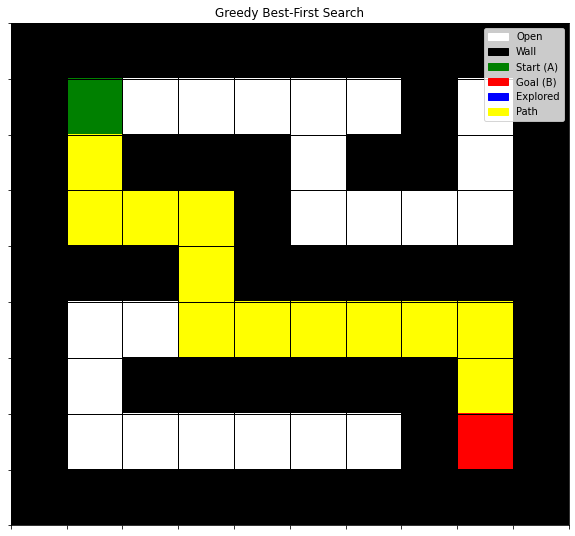


Solution fot: A* Search
Path found with 13 steps
Explored 23 states.


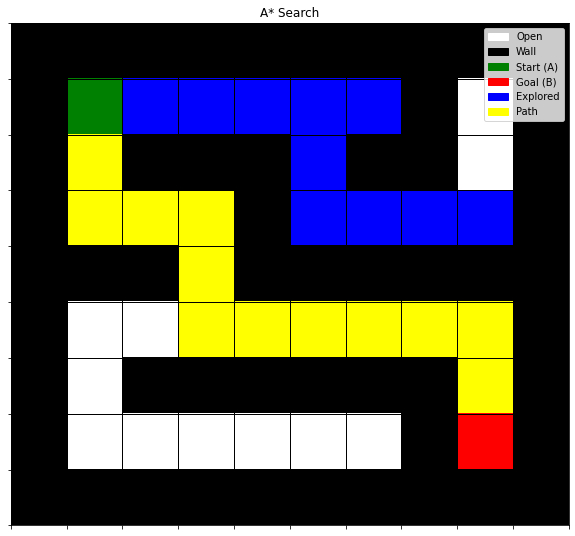

In [9]:
def main():
    maze_file = r"C:\Users\Liam\Downloads\maze3.txt"  #file
    maze = Maze(maze_file)
    
    #Greedy Best-First Search
    print("Solution for: Greedy Best-First Search")
    greedy_path, greedy_explored = maze.solve(algorithm="greedy")
    print(f"Path found with {len(greedy_path)} steps.")
    print(f"Explored {len(greedy_explored)} states.")
    
    maze.visualize(
        path=greedy_path,
        explored=greedy_explored,
        algorithm_name="Greedy Best-First Search"  #title
    )
    
    print("\nSolution fot: A* Search")
    astar_path, astar_explored = maze.solve(algorithm="a_star")
    print(f"Path found with {len(astar_path)} steps")
    print(f"Explored {len(astar_explored)} states.")
    
    ##visual representation
    maze.visualize(
        path=astar_path,
        explored=astar_explored,
        algorithm_name="A* Search" #maze title
    )

if __name__ == "__main__":
    main()

Solution for: Greedy Best-First Search
Path found with 39 steps.
Explored 55 states.


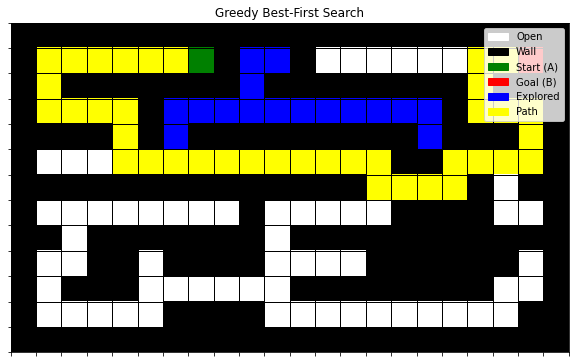


Solution fot: A* Search
Path found with 39 steps
Explored 62 states.


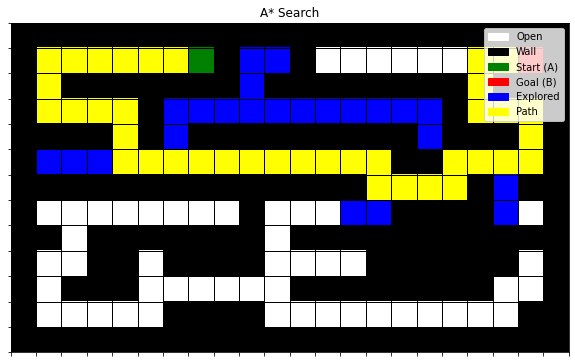

In [14]:
def main():
    maze_file = r"C:\Users\Liam\Downloads\maze.txt"  #file
    maze = Maze(maze_file)
    
    #Greedy Best-First Search
    print("Solution for: Greedy Best-First Search")
    greedy_path, greedy_explored = maze.solve(algorithm="greedy")
    print(f"Path found with {len(greedy_path)} steps.")
    print(f"Explored {len(greedy_explored)} states.")
    
    maze.visualize(
        path=greedy_path,
        explored=greedy_explored,
        algorithm_name="Greedy Best-First Search"  #title
    )
    
    print("\nSolution fot: A* Search")
    astar_path, astar_explored = maze.solve(algorithm="a_star")
    print(f"Path found with {len(astar_path)} steps")
    print(f"Explored {len(astar_explored)} states.")
    
    ##visual representation
    maze.visualize(
        path=astar_path,
        explored=astar_explored,
        algorithm_name="A* Search" #maze title
    )

if __name__ == "__main__":
    main()